In [23]:
import json
import numpy as np
import math

In [ ]:
# --- Step 1: Configuration ---
# Specify the paths to your JSON data files.
# Based on the MATLAB script inputs [4, 5], you likely need data from:
# 1. A static trial with anatomical markers (for 'joints' input)
# 2. A static trial with tracking markers (for 'neutral' input)
# 3. A dynamic trial with tracking markers (for 'dynamic' input)
# The data might be in one or multiple .json files depending on dataset organization.
# Example: Assuming separate files for static anatomical, static neutral, and dynamic data.
filepath = '/mnt/d/code/stridecare/101739/20160524T194935.json'


# Specify the keys used within the JSON files to access the data.
# These keys are NOT provided in the source excerpts and must be determined
# by inspecting the actual .json file structure [2].
# Placeholder keys below:
HZ_KEY = 'hz_r' # Placeholder key for sampling frequency [2]
STATIC_JOINTS_MARKERS_KEY = 'joints' # Placeholder key for anatomical markers in static trial [2]
STATIC_NEUTRAL_MARKERS_KEY = 'neutral' # Placeholder key for tracking markers in static trial [2]
DYNAMIC_MARKERS_KEY = 'running' # Placeholder key for tracking markers in dynamic trial [2]

# --- Step 2: Load Data ---

# Initialize variables to hold the loaded data
joints = None
neutral = None
dynamic = None
hz = None

print("Attempting to load data...")
# Load static joint data (anatomical markers)
try:
    with open('20110531T161051.json' , 'r') as f:
        static_joints_json_data = json.load(f)

    # Extract anatomical marker data using the specified key
    # The MATLAB script uses specific joint marker names like L_hip, L_lat_knee etc. [7]
    # Assume the JSON contains a structure mapping these names to 3D coordinates.
    # You might need to adapt this parsing based on the actual JSON structure.
    raw_joints_markers = static_joints_json_data.get(STATIC_JOINTS_MARKERS_KEY, {})

    # Convert relevant markers to numpy arrays, matching MATLAB script's expected inputs [7]
    joints = {}
    # List out the specific markers the MATLAB script uses for joint centers [7]
    required_joint_markers = [
        'L_hip', 'R_hip', 'L_lat_knee', 'L_med_knee',
        'R_lat_knee', 'R_med_knee', 'L_lat_ankle', 'L_med_ankle',
        'R_lat_ankle', 'R_med_ankle'
    ]
    for marker_name in required_joint_markers:
        # Check if the marker exists in the loaded data
        marker_data = raw_joints_markers.get(marker_name)
        if marker_data is not None:
             # Assuming static marker data is a simple list [x, y, z]
             joints[marker_name] = np.array(marker_data)
        else:
            print(f"Warning: Anatomical marker '{marker_name}' not found in {filepath}")
            # Handle missing data appropriately - e.g., skip subject, use default, etc.
            # For this example, we'll just print a warning. The rest of the script might fail.

    print(f"Loaded static joints data from {filepath}")

except FileNotFoundError:
    print(f"Error: Static joints file not found at {filepath}")
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {filepath}")
except Exception as e:
    print(f"An error occurred loading static joints data: {e}")

# Load static neutral data (tracking markers in neutral pose)
try:
    with open('20110531T161051.json' , 'r') as f:
        static_neutral_json_data = json.load(f)

    # Extract tracking marker data for the static neutral pose
    # Assume the JSON contains a structure mapping marker names to time-series data.
    # For the static neutral pose, we need the data from the first frame.
    raw_neutral_markers = static_neutral_json_data.get(STATIC_NEUTRAL_MARKERS_KEY, {})

    neutral = {}
    # List out the specific markers the MATLAB script uses for segment definitions [7-27]
    required_neutral_markers = [
        'pelvis_1', 'pelvis_2', 'pelvis_3', 'pelvis_4',
        'L_foot_1', 'L_foot_2', 'L_foot_3', 'L_foot_4', # Note: The script mentions 3 markers for L_foot/R_foot initially, then uses 4 later [10, 13, 23]
        'R_foot_1', 'R_foot_2', 'R_foot_3', 'R_foot_4',
        'L_shank_1', 'L_shank_2', 'L_shank_3', 'L_shank_4',
        'R_shank_1', 'R_shank_2', 'R_shank_3', 'R_shank_4',
        'L_thigh_1', 'L_thigh_2', 'L_thigh_3', 'L_thigh_4',
        'R_thigh_1', 'R_thigh_2', 'R_thigh_3', 'R_thigh_4', 'L_toe', 'R_toe'
    ]

    for marker_name in required_neutral_markers:
        marker_data_series = raw_neutral_markers.get(marker_name)
        if marker_data_series is not None and len(marker_data_series) > 0:
            # Assuming the static neutral data is the first frame of the time series
            neutral[marker_name] = np.array(marker_data_series) # Take the first frame
        else:
            print(f"Warning: Tracking marker '{marker_name}' not found or empty in {filepath}")
            # Handle missing data appropriately

    print(f"Loaded static neutral data from {filepath}")

except FileNotFoundError:
    print(f"Error: Static neutral file not found at {filepath}")
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {filepath}")
except Exception as e:
    print(f"An error occurred loading static neutral data: {e}")

# Load dynamic data (tracking markers time-series and sampling frequency)
try:
    with open('20110531T161051.json' , 'r') as f:
        dynamic_json_data = json.load(f)

    # Extract sampling frequency [2, 4]
    hz = dynamic_json_data.get(HZ_KEY)
    if hz is None:
        print(f"Warning: Sampling frequency key '{HZ_KEY}' not found in {filepath}")
        # Handle missing frequency, maybe use a default or skip analysis
        # hz = 120 # Example default value - verify with dataset documentation

    # Extract dynamic tracking marker data [2, 6]
    # Assume the JSON contains a structure mapping marker names to time-series data.
    raw_dynamic_markers = dynamic_json_data.get(DYNAMIC_MARKERS_KEY, {})

    dynamic = {}
    # List out the specific markers the MATLAB script uses for dynamic tracking [33, 34]
    required_dynamic_markers = [
        'pelvis_1', 'pelvis_2', 'pelvis_3', 'pelvis_4',
        'L_foot_1', 'L_foot_2', 'L_foot_3', 'L_foot_4',
        'R_foot_1', 'R_foot_2', 'R_foot_3', 'R_foot_4',
        'L_shank_1', 'L_shank_2', 'L_shank_3', 'L_shank_4',
        'R_shank_1', 'R_shank_2', 'R_shank_3', 'R_shank_4',
        'L_thigh_1', 'L_thigh_2', 'L_thigh_3', 'L_thigh_4',
        'R_thigh_1', 'R_thigh_2', 'R_thigh_3', 'R_thigh_4', 'L_toe', 'R_toe'
    ]

    # Get the number of frames from one of the marker lists to ensure consistency
    # This is analogous to how MATLAB preallocates using length(dynamic.L_foot_1(:,1)) [31]
    num_frames = 0
    if required_dynamic_markers[0] in raw_dynamic_markers:
         num_frames = len(raw_dynamic_markers[required_dynamic_markers[0]])
    else:
         print("Warning: Could not determine number of frames from dynamic data.")

    for marker_name in required_dynamic_markers:
        marker_data_series = raw_dynamic_markers[marker_name]
        if marker_data_series is not None and len(marker_data_series) == num_frames:
            # Convert the list of [x, y, z] frames into a numpy array (num_frames x 3)
            dynamic[marker_name] = np.array(marker_data_series)
        else:
            print(f"Warning: Tracking marker '{marker_name}' not found or has inconsistent length in {filepath}")
            # Handle missing or inconsistent data appropriately

    print(f"Loaded dynamic data from {filepath}")

except FileNotFoundError:
    print(f"Error: Dynamic file not found at {filepath}")
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {filepath}")
except Exception as e:
    print(f"An error occurred loading dynamic data: {e}")

Attempting to load data...
Loaded static joints data from /mnt/d/code/stridecare/101739/20160524T194935.json
Loaded static neutral data from /mnt/d/code/stridecare/101739/20160524T194935.json
Loaded dynamic data from /mnt/d/code/stridecare/101739/20160524T194935.json


In [25]:
# --- Step 3: Verification (Optional) ---
# Check if all required data was loaded successfully before proceeding
if joints is not None and neutral is not None and dynamic is not None and hz is not None:
    print("\nAll required data structures loaded successfully.")
    print(f"Sampling Frequency (hz): {hz}")
    # You can add further checks here, e.g., verify the number of markers loaded
    # and the dimensions of the arrays match expectations.
    print(f"Loaded {len(joints)} static joint markers.")
    print(f"Loaded {len(neutral)} static neutral markers.")
    print(f"Loaded {len(dynamic)} dynamic tracking markers over {num_frames} frames.")
else:
    print("\nFailed to load all required data. Kinematics analysis cannot proceed.")

# Now you would pass 'joints', 'neutral', 'dynamic', and 'hz'
# to the Python functions implementing the rest of the gait_kinematics logic.


All required data structures loaded successfully.
Sampling Frequency (hz): 200
Loaded 10 static joint markers.
Loaded 30 static neutral markers.
Loaded 30 dynamic tracking markers over 4000 frames.


In [26]:
# Compute joint centers
jc = {}

# Average of four pelvis points
jc['pelvis'] = (neutral['pelvis_1'] + neutral['pelvis_2'] +
                neutral['pelvis_3'] + neutral['pelvis_4']) / 4

# 25% of the distance between hips
jc['L_hip'] = joints['L_hip'] + (joints['R_hip'] - joints['L_hip']) / 4
jc['R_hip'] = joints['R_hip'] + (joints['L_hip'] - joints['R_hip']) / 4

# Midpoint of the two knee markers
jc['L_knee'] = (joints['L_lat_knee'] + joints['L_med_knee']) / 2
jc['R_knee'] = (joints['R_lat_knee'] + joints['R_med_knee']) / 2

# Midpoint of the two ankle markers
jc['L_ankle'] = (joints['L_lat_ankle'] + joints['L_med_ankle']) / 2
jc['R_ankle'] = (joints['R_med_ankle'] + joints['R_lat_ankle']) / 2

In [27]:
jc

{'pelvis': array([  29.10661391, 1004.41250084,  -56.47373973]),
 'L_hip': array([ -66.35976454,  914.79726791, -144.48109604]),
 'R_hip': array([ 105.34121405,  909.76965042, -159.87907089]),
 'L_knee': array([-111.360105  ,  488.21584259, -116.09579391]),
 'R_knee': array([ 120.17281943,  493.52307663, -120.39383392]),
 'L_ankle': array([-137.88063542,   99.44611594, -107.54856368]),
 'R_ankle': array([ 146.11683403,  101.09730183, -104.51803282])}

In [28]:
# LEFT FOOT
# Long axis of the foot is aligned with the lab
l_foot_x = np.array([0, 0, -1])

# Combine 3 of the foot markers into one matrix (ignore the created fourth)
L_foot = np.array([
    neutral['L_foot_1'],
    neutral['L_foot_2'],
    neutral['L_foot_3']
])

# Sort the markers from left to right (based on x-coordinate)
L_foot = L_foot[np.argsort(L_foot[:, 0])]

# Create a vector from the two right markers (the leftmost is lateral heel)
l_foot_temp = L_foot[1] - L_foot[2]
l_foot_temp /= np.linalg.norm(l_foot_temp)

# Check that it is pointing up ... and if not, flip it
if l_foot_temp[1] < 0:
    l_foot_temp = -l_foot_temp

# Use the temp vertical axis to create the lateral axis (z-axis)
l_foot_z = np.cross(l_foot_x, l_foot_temp)
l_foot_z /= np.linalg.norm(l_foot_z)

# Create the 'vertical' axis (y-axis) that provides standing eversion angle
l_foot_y = np.cross(l_foot_z, l_foot_x)
l_foot_y /= np.linalg.norm(l_foot_y)

# Combine to create a transformation matrix from anatomical to global
ag = {}
ag['L_foot'] = np.column_stack((l_foot_x, l_foot_y, l_foot_z))
ag

{'L_foot': array([[ 0.00000000e+00,  7.70580018e-04,  9.99999703e-01],
        [ 0.00000000e+00,  9.99999703e-01, -7.70580018e-04],
        [-1.00000000e+00,  0.00000000e+00,  0.00000000e+00]])}

In [29]:
# RIGHT FOOT
# Long axis of the foot is aligned with the lab
r_foot_x = np.array([0, 0, -1])

# Combine 3 foot markers into one matrix (ignore any fourth marker)
R_foot = np.array([
    neutral['R_foot_1'],
    neutral['R_foot_2'],
    neutral['R_foot_3']
])

# Sort the markers from left to right (based on x-coordinate)
R_foot = R_foot[np.argsort(R_foot[:, 0])]

# Create a vector from the two left markers (not the lateral one)
r_foot_temp = R_foot[0] - R_foot[1]
r_foot_temp /= np.linalg.norm(r_foot_temp)

# Ensure the vector is pointing upward
if r_foot_temp[1] < 0:
    r_foot_temp = -r_foot_temp

# Compute the lateral axis (z-axis)
r_foot_z = np.cross(r_foot_x, r_foot_temp)
r_foot_z /= np.linalg.norm(r_foot_z)

# Compute the vertical axis (y-axis) with standing eversion
r_foot_y = np.cross(r_foot_z, r_foot_x)
r_foot_y /= np.linalg.norm(r_foot_y)

# Combine to create the transformation matrix from anatomical to global
ag['R_foot'] = np.column_stack((r_foot_x, r_foot_y, r_foot_z))
ag

{'L_foot': array([[ 0.00000000e+00,  7.70580018e-04,  9.99999703e-01],
        [ 0.00000000e+00,  9.99999703e-01, -7.70580018e-04],
        [-1.00000000e+00,  0.00000000e+00,  0.00000000e+00]]),
 'R_foot': array([[ 0.        , -0.02226942,  0.99975201],
        [ 0.        ,  0.99975201,  0.02226942],
        [-1.        ,  0.        ,  0.        ]])}

In [30]:
# LEFT SHANK

# Long axis (Y) pointing up from ankle to knee
l_shank_y = jc['L_knee'] - jc['L_ankle']
l_shank_y /= np.linalg.norm(l_shank_y)

# Temporary vector approximating the hinge joint (medial to lateral ankle)
l_shank_temp = joints['L_med_ankle'] - joints['L_lat_ankle']
l_shank_temp /= np.linalg.norm(l_shank_temp)

# Anterior axis (X) from cross product
l_shank_x = np.cross(l_shank_y, l_shank_temp)
l_shank_x /= np.linalg.norm(l_shank_x)

# Hinge axis (Z), pointing to the right
l_shank_z = np.cross(l_shank_x, l_shank_y)
l_shank_z /= np.linalg.norm(l_shank_z)

# Combine to create transformation matrix from anatomical to global
ag['L_shank'] = np.column_stack((l_shank_x, l_shank_y, l_shank_z))

# RIGHT SHANK

# Long axis (Y) pointing up from ankle to knee
r_shank_y = jc['R_knee'] - jc['R_ankle']
r_shank_y /= np.linalg.norm(r_shank_y)

# Temporary hinge-like vector from medial to lateral ankle
r_shank_temp = joints['R_lat_ankle'] - joints['R_med_ankle']
r_shank_temp /= np.linalg.norm(r_shank_temp)

# Anterior axis (X) from cross product
r_shank_x = np.cross(r_shank_y, r_shank_temp)
r_shank_x /= np.linalg.norm(r_shank_x)

# Lateral hinge axis (Z)
r_shank_z = np.cross(r_shank_x, r_shank_y)
r_shank_z /= np.linalg.norm(r_shank_z)

# Combine to create transformation matrix from anatomical to global
ag['R_shank'] = np.column_stack((r_shank_x, r_shank_y, r_shank_z))
ag

{'L_foot': array([[ 0.00000000e+00,  7.70580018e-04,  9.99999703e-01],
        [ 0.00000000e+00,  9.99999703e-01, -7.70580018e-04],
        [-1.00000000e+00,  0.00000000e+00,  0.00000000e+00]]),
 'R_foot': array([[ 0.        , -0.02226942,  0.99975201],
        [ 0.        ,  0.99975201,  0.02226942],
        [-1.        ,  0.        ,  0.        ]]),
 'L_shank': array([[-0.24518307,  0.06804202,  0.96708611],
        [-0.00458848,  0.99744143, -0.07134105],
        [-0.96946594, -0.02192908, -0.24424354]]),
 'R_shank': array([[ 0.26964757, -0.06591421,  0.96070053],
        [-0.02112076,  0.99700975,  0.07433354],
        [-0.96272743, -0.04033458,  0.2674491 ]])}

In [31]:
# LEFT THIGH

# Long axis (Y): from knee to hip
l_thigh_y = jc['L_hip'] - jc['L_knee']
l_thigh_y /= np.linalg.norm(l_thigh_y)

# Approximate hinge axis from medial to lateral knee
l_thigh_temp = joints['L_med_knee'] - joints['L_lat_knee']
l_thigh_temp /= np.linalg.norm(l_thigh_temp)

# Anterior axis (X)
l_thigh_x = np.cross(l_thigh_y, l_thigh_temp)
l_thigh_x /= np.linalg.norm(l_thigh_x)

# Hinge axis (Z)
l_thigh_z = np.cross(l_thigh_x, l_thigh_y)
l_thigh_z /= np.linalg.norm(l_thigh_z)

# Transformation matrix
ag['L_thigh'] = np.column_stack((l_thigh_x, l_thigh_y, l_thigh_z))

# RIGHT THIGH

# Long axis (Y): from knee to hip
r_thigh_y = jc['R_hip'] - jc['R_knee']
r_thigh_y /= np.linalg.norm(r_thigh_y)

# Approximate hinge axis from medial to lateral knee
r_thigh_temp = joints['R_lat_knee'] - joints['R_med_knee']
r_thigh_temp /= np.linalg.norm(r_thigh_temp)

# Anterior axis (X)
r_thigh_x = np.cross(r_thigh_y, r_thigh_temp)
r_thigh_x /= np.linalg.norm(r_thigh_x)

# Hinge axis (Z)
r_thigh_z = np.cross(r_thigh_x, r_thigh_y)
r_thigh_z /= np.linalg.norm(r_thigh_z)

# Transformation matrix
ag['R_thigh'] = np.column_stack((r_thigh_x, r_thigh_y, r_thigh_z))
ag

{'L_foot': array([[ 0.00000000e+00,  7.70580018e-04,  9.99999703e-01],
        [ 0.00000000e+00,  9.99999703e-01, -7.70580018e-04],
        [-1.00000000e+00,  0.00000000e+00,  0.00000000e+00]]),
 'R_foot': array([[ 0.        , -0.02226942,  0.99975201],
        [ 0.        ,  0.99975201,  0.02226942],
        [-1.        ,  0.        ,  0.        ]]),
 'L_shank': array([[-0.24518307,  0.06804202,  0.96708611],
        [-0.00458848,  0.99744143, -0.07134105],
        [-0.96946594, -0.02192908, -0.24424354]]),
 'R_shank': array([[ 0.26964757, -0.06591421,  0.96070053],
        [-0.02112076,  0.99700975,  0.07433354],
        [-0.96272743, -0.04033458,  0.2674491 ]]),
 'L_thigh': array([[-0.071999  ,  0.10467957,  0.99189633],
        [-0.05865856,  0.99231157, -0.10898125],
        [-0.99567832, -0.06602975, -0.06530509]]),
 'R_thigh': array([[ 0.00569861, -0.03545024,  0.9993552 ],
        [-0.09423349,  0.99490516,  0.03582973],
        [-0.99553381, -0.09437691,  0.00232898]])}

In [32]:
# PELVIS
# Fixed axes based on lab frame (since trochanters are hard to landmark)
pelvis_x = np.array([0, 0, -1])  # anterior
pelvis_y = np.array([0, 1, 0])   # vertical (up)
pelvis_z = np.array([1, 0, 0])   # lateral (to subject's right)

# Combine to create transformation matrix from anatomical to global
ag['pelvis'] = np.column_stack((pelvis_x, pelvis_y, pelvis_z))
ag

{'L_foot': array([[ 0.00000000e+00,  7.70580018e-04,  9.99999703e-01],
        [ 0.00000000e+00,  9.99999703e-01, -7.70580018e-04],
        [-1.00000000e+00,  0.00000000e+00,  0.00000000e+00]]),
 'R_foot': array([[ 0.        , -0.02226942,  0.99975201],
        [ 0.        ,  0.99975201,  0.02226942],
        [-1.        ,  0.        ,  0.        ]]),
 'L_shank': array([[-0.24518307,  0.06804202,  0.96708611],
        [-0.00458848,  0.99744143, -0.07134105],
        [-0.96946594, -0.02192908, -0.24424354]]),
 'R_shank': array([[ 0.26964757, -0.06591421,  0.96070053],
        [-0.02112076,  0.99700975,  0.07433354],
        [-0.96272743, -0.04033458,  0.2674491 ]]),
 'L_thigh': array([[-0.071999  ,  0.10467957,  0.99189633],
        [-0.05865856,  0.99231157, -0.10898125],
        [-0.99567832, -0.06602975, -0.06530509]]),
 'R_thigh': array([[ 0.00569861, -0.03545024,  0.9993552 ],
        [-0.09423349,  0.99490516,  0.03582973],
        [-0.99553381, -0.09437691,  0.00232898]]),
 'pelv

In [33]:
ac = {}
djc = {}

# Helper function to compute transformed markers and joint center
def transform_segment_markers(segment, marker_names, joint_center_name):
    # Transform all segment markers to anatomical coordinates
    transformed = [ag[segment].T @ neutral[marker].T for marker in marker_names]
    ac[segment] = np.column_stack(transformed)

    # Compute segment centroid
    centroid = np.mean(ac[segment], axis=1)

    # Joint center in anatomical coordinates relative to segment centroid
    djc_name = joint_center_name.split('.')[-1]
    djc[djc_name] = ag[segment].T @ jc[djc_name].T - centroid

# LEFT FOOT
transform_segment_markers(
    'L_foot', ['L_foot_1', 'L_foot_2', 'L_foot_3', 'L_foot_4'], 'jc.L_ankle'
)

# RIGHT FOOT
transform_segment_markers(
    'R_foot', ['R_foot_1', 'R_foot_2', 'R_foot_3', 'R_foot_4'], 'jc.R_ankle'
)

# LEFT SHANK
transform_segment_markers(
    'L_shank', ['L_shank_1', 'L_shank_2', 'L_shank_3', 'L_shank_4'], 'jc.L_knee'
)

# RIGHT SHANK
transform_segment_markers(
    'R_shank', ['R_shank_1', 'R_shank_2', 'R_shank_3', 'R_shank_4'], 'jc.R_knee'
)

# LEFT THIGH
transform_segment_markers(
    'L_thigh', ['L_thigh_1', 'L_thigh_2', 'L_thigh_3', 'L_thigh_4'], 'jc.L_hip'
)

# RIGHT THIGH
transform_segment_markers(
    'R_thigh', ['R_thigh_1', 'R_thigh_2', 'R_thigh_3', 'R_thigh_4'], 'jc.R_hip'
)

# PELVIS
transform_segment_markers(
    'pelvis', ['pelvis_1', 'pelvis_2', 'pelvis_3', 'pelvis_4'], 'jc.pelvis'
)

In [34]:
djc

{'L_ankle': array([65.64910582, 50.98303332, 15.36444234]),
 'R_ankle': array([ 61.29799767,  55.7586105 , -13.92454294]),
 'L_knee': array([ 36.63081379, 279.80773798,  37.92675257]),
 'R_knee': array([ 46.12696854, 268.28009857, -42.78809228]),
 'L_hip': array([ 57.19863726, 224.48356232,  44.68831082]),
 'R_hip': array([ 61.77578142, 222.49341389, -41.62312479]),
 'pelvis': array([0., 0., 0.])}

In [35]:
avg = {}
dif = {}

# Helper function to compute average and difference from average
def compute_avg_and_dif(segment_name, ac_segment_data):
    # Compute average marker position (column-wise mean)
    avg_vector = np.mean(ac_segment_data, axis=1)  # shape (3,)
    avg[f'ac_{segment_name}'] = avg_vector

    # Compute differences from average for each marker
    dif_matrix = ac_segment_data - avg_vector[:, np.newaxis]  # shape (3, N)
    dif[f'ac_{segment_name}'] = dif_matrix

# Apply to all segments
compute_avg_and_dif('L_foot', ac['L_foot'])
compute_avg_and_dif('R_foot', ac['R_foot'])
compute_avg_and_dif('L_shank', ac['L_shank'])
compute_avg_and_dif('R_shank', ac['R_shank'])
compute_avg_and_dif('L_thigh', ac['L_thigh'])
compute_avg_and_dif('R_thigh', ac['R_thigh'])
compute_avg_and_dif('pelvis', ac['pelvis'])

In [36]:
dif

{'ac_L_foot': array([[-6.59860357e+00, -1.45886114e+01,  2.11872148e+01,
          8.34465013e-08],
        [ 3.70322361e+01, -2.11254357e+01, -1.59068004e+01,
         -2.23720775e-09],
        [ 1.44366820e+01,  1.44366820e+01, -2.88733641e+01,
          1.90736642e-07]]),
 'ac_R_foot': array([[-9.07774345e+00, -1.55040261e+01,  2.45817696e+01,
         -3.33785977e-08],
        [ 3.25315347e+01, -1.41076455e+01, -1.84238892e+01,
          1.78645436e-08],
        [-1.73265256e+01, -1.73265256e+01,  3.46530515e+01,
         -2.66697100e-07]]),
 'ac_L_shank': array([[ 18.11558994, -24.48856614, -18.74493571,  25.11791191],
        [ 25.84947913,  26.43224464, -24.00616611, -28.27555766],
        [-25.74897321,  10.69681056,  28.11740394, -13.06524129]]),
 'ac_R_shank': array([[ 19.46627575, -21.83162883, -14.45434448,  16.81969756],
        [ 27.04864118,  24.67385907, -26.59818847, -25.12431179],
        [ 25.37707568, -19.72139175, -20.33760694,  14.68192301]]),
 'ac_L_thigh': array

In [37]:
# Number of frames in dynamic data (assuming dynamic.L_foot_1 is a NumPy array shape [frames, coords])
n_frames = dynamic['L_foot_1'].shape[0]

# Preallocate rotation matrices (4x4xN)
R = {
    'L_foot': np.zeros((4, 4, n_frames)),
    'R_foot': np.zeros((4, 4, n_frames)),
    'L_shank': np.zeros((4, 4, n_frames)),
    'R_shank': np.zeros((4, 4, n_frames)),
    'L_thigh': np.zeros((4, 4, n_frames)),
    'R_thigh': np.zeros((4, 4, n_frames)),
    'pelvis': np.zeros((4, 4, n_frames)),
    'L_ankle': np.zeros((4, 4, n_frames)),
    'R_ankle': np.zeros((4, 4, n_frames)),
    'L_knee': np.zeros((4, 4, n_frames)),
    'R_knee': np.zeros((4, 4, n_frames)),
    'L_hip': np.zeros((4, 4, n_frames)),
    'R_hip': np.zeros((4, 4, n_frames)),
}

# Preallocate angle arrays (same shape as dynamic marker data)
angle = {}
for key in ['L_ankle', 'R_ankle', 'L_knee', 'R_knee', 'L_hip', 'R_hip', 'L_foot', 'R_foot', 'pelvis']:
    angle[key] = np.zeros_like(dynamic['L_foot_1'])  # assuming shape (frames, coords)

In [38]:
angle

{'L_ankle': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'R_ankle': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'L_knee': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'R_knee': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'L_hip': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'R_hip': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'L_foot': array([[0., 0., 0.],
        [0., 0., 0.],
    

In [ ]:
avg_ac = {}
dif_ac = {}

for seg in ['L_foot', 'R_foot', 'L_shank', 'R_shank', 'L_thigh', 'R_thigh', 'pelvis']:
    # avg_ac[seg] should be shape (3,1).  mean across columns → (3,), keepdims→(3,1)
    avg_ac[seg] = np.mean(ac[seg], axis=1, keepdims=True)  # shape (3,1)

    # dif_ac[seg] is (3,4) minus that (3,1), yielding (3,4)
    dif_ac[seg] = ac[seg] - avg_ac[seg]  # shape (3,4)

In [ ]:
def cardanangles(R3):
    """
    Compute Cardan (
    ) angles from a 3×3 rotation matrix R3.
    Returns [Rx, Ry, Rz] in radians, following the same conventions
    as your MATLAB `cardanangles`:

      | Cz*Cy - Sz*Sy*Sx   Sz*Cy + Cz*Sy*Sx  -Sy*Cx |
      | -Sz*Cx             Cz*Cx              Sx     |
      | Cz*Sy + Sz*Cy*Sx   Sz*Sy - Cz*Cy*Sx  Cy*Cx  |

    That is: Rx about X, Ry about Y, Rz about Z.
    """
    # Extract relevant sine/cosine terms
    Sx = R3[2, 1]
    # Clamp for numerical stability
    Sx = np.clip(Sx, -1.0, 1.0)
    Cx = np.sqrt(1 - Sx**2)

    # Gimbal‐lock check
    if np.isclose(Cx, 0.0):
        # When Cx ≈ 0, we lose ability to uniquely find Rx vs Rz
        # Fallback: set Rz = 0, solve Rx from off‐diagonals
        Rx = np.arctan2(-R3[1, 2], R3[1, 1])
        Ry = np.arcsin(Sx)
        Rz = 0.0
    else:
        Rx = np.arctan2(Sx, R3[1, 1])
        Ry = np.arctan2(-R3[0, 2], R3[2, 2])
        Rz = np.arctan2(-R3[1, 0], R3[1, 1])

    return np.array([Rx, Ry, Rz])


# 1) Number of frames in the dynamic trial:
n_frames = dynamic['L_foot_1'].shape[0]

# 2) Loop over each frame:
for i in range(n_frames):
    # -----------------------------------------------------------------------
    # STEP A: Build each segment's 3×4 marker‐matrix from dynamic data
    #   d['L_foot'] will be shape (3,4), where each column is one marker.
    # -----------------------------------------------------------------------
    d = {}
    for seg in ['L_foot', 'R_foot', 'L_shank', 'R_shank', 'L_thigh', 'R_thigh', 'pelvis']:
        # Each dynamic marker array is shape (n_frames, 3)
        m1 = dynamic[f"{seg}_1"][i, :]  # shape (3,)
        m2 = dynamic[f"{seg}_2"][i, :]
        m3 = dynamic[f"{seg}_3"][i, :]
        m4 = dynamic[f"{seg}_4"][i, :]
        # Stack as columns → (3,4)
        d[seg] = np.column_stack((m1, m2, m3, m4))

    # -----------------------------------------------------------------------
    # STEP B: Compute the average marker position for each segment (3×1 vector)
    # -----------------------------------------------------------------------
    avg_d = {}
    for seg in d:
        # mean across columns (axis=1) → shape (3,), then reshape to (3,1)
        avg_vec = np.mean(d[seg], axis=1, keepdims=True)
        avg_d[f"d_{seg}"] = avg_vec  # e.g. avg_d['d_L_foot'] is (3,1)

    # -----------------------------------------------------------------------
    # STEP C: Compute difference from average for each segment: (3×4) − (3×1)
    # -----------------------------------------------------------------------
    dif_d = {}
    for seg in d:
        dif_d[f"d_{seg}"] = d[seg] - avg_d[f"d_{seg}"]  # broadcasts → shape (3,4)

    # -----------------------------------------------------------------------
    # STEP D (Soderkvist Step 3): Build C[seg] = dif_d * dif_ac^T  (3×4 @ 4×3 → 3×3)
    #    where dif_ac['L_foot'] etc. is the neutral‐trial difference (3×4).
    # -----------------------------------------------------------------------
    C = {}
    for seg in dif_d:
        # seg is e.g. 'd_L_foot'; neutral key should be 'L_foot'
        neutral_key = seg.split('_', 1)[1]  # e.g. 'L_foot'
        # dif_ac[neutral_key] must already exist (shape (3,4))
        C[seg] = dif_d[seg] @ dif_ac[neutral_key].T  # result is (3,3)

    # -----------------------------------------------------------------------
    # STEP E (Soderkvist Step 4): SVD on each C[seg]
    # -----------------------------------------------------------------------
    P = {}
    T = {}
    Q = {}
    for seg in C:
        # np.linalg.svd returns U, Σ, V^T. In MATLAB, [U,S,V] = svd(C) means C = U*S*V'
        U, S_vals, Vt = np.linalg.svd(C[seg], full_matrices=False)
        P[seg] = U         # shape (3,3)
        T[seg] = np.diag(S_vals)  # shape (3,3), though we only need P and Vt
        Q[seg] = Vt.T      # shape (3,3)

    # -----------------------------------------------------------------------
    # STEP F (Soderkvist Step 5): Build each 3×3 rotation matrix R_segs[seg]
    #   R = P * diag(1,1, sign(det(P*Q'))) * Q'
    # -----------------------------------------------------------------------
    R_segs = {}
    for seg in P:
        # Compute det(P * Q^T)
        det_val = np.linalg.det(P[seg] @ Q[seg].T)
        # Build D = diag(1,1, sign(det_val))
        D = np.diag([1, 1, np.sign(det_val)])
        # Final 3×3 rotation
        R_segs[seg] = P[seg] @ D @ Q[seg].T  # shape (3,3)

    # -----------------------------------------------------------------------
    # STEP G (Soderkvist Step 6): Calculate displacement = avg_d - R * avg_ac
    #   avg_ac[‘L_foot’] is the neutral‐trial anatomical average (3×1).
    # -----------------------------------------------------------------------
    dis = {}
    for seg in R_segs:
        neutral_key = seg.split('_', 1)[1]  # e.g. 'L_foot'
        # avg_ac[neutral_key] must exist (shape (3,1))
        dis[seg] = avg_d[seg] - R_segs[seg] @ avg_ac[neutral_key]  # shape (3,1)

    # -----------------------------------------------------------------------
    # STEP H: Pack each 3×3 + 3×1 into a 4×4 homogeneous matrix, store in R[seg_name]
    #   The dictionary key in R should be just 'L_foot', etc., not 'd_L_foot'.
    # -----------------------------------------------------------------------
    for seg in R_segs:
        seg_name = seg.split('_', 1)[1]  # strip leading 'd_', e.g. 'L_foot'
        # build a 4×4 block:
        R[seg_name][:, :, i] = np.vstack([
            np.hstack([R_segs[seg], dis[seg]]),
            np.array([[0, 0, 0, 1]])
        ])

    # -----------------------------------------------------------------------
    # STEP I: Compute segment‐level “foot” angles, pelvis angles, etc.
    #   – EXACTLY as in your MATLAB, simply using np.arctan / np.arctan2
    # -----------------------------------------------------------------------
    # LEFT FOOT angles:
    R_Lf = R['L_foot']  # shape (4,4,n_frames)
    angle['L_foot'][i, 0] = np.arctan(
        R_Lf[0, 1, i] / np.sqrt(R_Lf[1, 1, i]**2 + R_Lf[2, 1, i]**2)
    )
    angle['L_foot'][i, 1] = np.arctan(
        -R_Lf[0, 0, i] / np.sqrt(R_Lf[1, 0, i]**2 + R_Lf[2, 0, i]**2)
    )
    angle['L_foot'][i, 2] = np.arctan2(
        R_Lf[1, 0, i], -R_Lf[2, 0, i]
    )

    # RIGHT FOOT angles:
    R_Rf = R['R_foot']
    angle['R_foot'][i, 0] = np.arctan(
        R_Rf[0, 1, i] / np.sqrt(R_Rf[1, 1, i]**2 + R_Rf[2, 1, i]**2)
    )
    angle['R_foot'][i, 1] = np.arctan(
        R_Rf[0, 0, i] / np.sqrt(R_Rf[1, 0, i]**2 + R_Rf[2, 0, i]**2)
    )
    angle['R_foot'][i, 2] = np.arctan2(
        R_Rf[1, 0, i], -R_Rf[2, 0, i]
    )

    # PELVIS angles:
    R_pv = R['pelvis']
    angle['pelvis'][i, 0] = np.arctan2(
        R_pv[0, 2, i], R_pv[2, 2, i]
    ) - (np.pi / 2)
    angle['pelvis'][i, 1] = np.arctan(
        R_pv[1, 2, i] / R_pv[0, 2, i]
    )
    angle['pelvis'][i, 2] = np.arctan2(
        R_pv[1, 0, i], -R_pv[2, 0, i]
    )

    # -----------------------------------------------------------------------
    # STEP J: Compute inter‐segment (joint) rotation matrices, then joint angles
    #   R_shank^T * R_foot  → ankle;  R_thigh^T * R_shank → knee;  R_pelvis^T * R_thigh → hip
    # -----------------------------------------------------------------------
    R['L_ankle'][:, :, i] = R['L_shank'][:, :, i].T @ R['L_foot'][:, :, i]
    R['R_ankle'][:, :, i] = R['R_shank'][:, :, i].T @ R['R_foot'][:, :, i]
    R['L_knee'][:, :, i]  = R['L_thigh'][:, :, i].T @ R['L_shank'][:, :, i]
    R['R_knee'][:, :, i]  = R['R_thigh'][:, :, i].T @ R['R_shank'][:, :, i]
    R['L_hip'][:, :, i]   = R['pelvis'][:, :, i].T @ R['L_thigh'][:, :, i]
    R['R_hip'][:, :, i]   = R['pelvis'][:, :, i].T @ R['R_thigh'][:, :, i]

    # Now extract 3×3 sub‐block and feed to cardanangles:
    angle['L_ankle'][i, :] = cardanangles(R['L_ankle'][:3, :3, i])
    angle['R_ankle'][i, :] = cardanangles(R['R_ankle'][:3, :3, i])
    angle['L_knee'][i, :]  = cardanangles(R['L_knee'][:3, :3, i])
    angle['R_knee'][i, :]  = cardanangles(R['R_knee'][:3, :3, i])
    angle['L_hip'][i, :]   = cardanangles(R['L_hip'][:3, :3, i])
    angle['R_hip'][i, :]   = cardanangles(R['R_hip'][:3, :3, i])

In [41]:
angle

{'L_ankle': array([[-0.0365189 ,  0.20007936,  0.37617528],
        [-0.04354594,  0.18123161,  0.37716222],
        [-0.05026703,  0.16271484,  0.37763249],
        ...,
        [-0.08513311,  0.1887551 , -0.16099201],
        [-0.0860368 ,  0.18825729, -0.1620855 ],
        [-0.08680343,  0.18819909, -0.16270611]]),
 'R_ankle': array([[ 0.12345868, -0.37193273, -0.15859612],
        [ 0.13022374, -0.37863443, -0.16402307],
        [ 0.13626269, -0.38454077, -0.16880502],
        ...,
        [ 0.1284454 , -0.27160313, -0.21670436],
        [ 0.1292205 , -0.27840589, -0.19512926],
        [ 0.12937706, -0.28458227, -0.17546956]]),
 'L_knee': array([[ 0.10612802, -0.13530207,  0.35149441],
        [ 0.10976242, -0.13498758,  0.38543986],
        [ 0.11350341, -0.1343265 ,  0.420953  ],
        ...,
        [-0.23619411, -0.31365377,  1.02814865],
        [-0.22697516, -0.33136183,  0.9875704 ],
        [-0.21847501, -0.34649964,  0.9511475 ]]),
 'R_knee': array([[-0.08467664,  0.514975

In [42]:
# 1) Convert angles from radians to degrees
angles = {}
for seg in ['L_ankle', 'R_ankle', 'L_knee', 'R_knee',
            'L_hip', 'R_hip', 'L_foot', 'R_foot', 'pelvis']:
    angles[seg] = np.degrees(angle[seg])  # same shape as angle[seg], now in degrees

# 2) Calculate joint angular velocities (deg/s)
velocities = {}
for seg in angles:
    # np.diff along axis=0 computes frame‐to‐frame change; multiply by sampling freq hz
    velocities[seg] = np.diff(angles[seg], axis=0) * hz

In [43]:
angles

{'L_ankle': array([[-2.09237867, 11.46370292, 21.55325598],
        [-2.49499875, 10.38380619, 21.60980335],
        [-2.8800886 ,  9.32287334, 21.63674781],
        ...,
        [-4.87776786, 10.81487068, -9.22416257],
        [-4.92954534, 10.7863484 , -9.28681498],
        [-4.97347003, 10.78301347, -9.32237332]]),
 'R_ankle': array([[  7.07366126, -21.31017558,  -9.08688821],
        [  7.46127049, -21.69415503,  -9.39782955],
        [  7.8072772 , -22.03256299,  -9.67181515],
        ...,
        [  7.35937949, -15.56171306, -12.41624502],
        [  7.40378908, -15.95148254, -11.18008294],
        [  7.41275957, -16.30536309, -10.0536653 ]]),
 'L_knee': array([[  6.08068753,  -7.75223769,  20.13914633],
        [  6.28892331,  -7.7342184 ,  22.0840775 ],
        [  6.50326658,  -7.69634164,  24.11883006],
        ...,
        [-13.53292562, -17.97103746,  58.90857832],
        [-13.00471868, -18.98563462,  56.58361575],
        [-12.51769605, -19.85296713,  54.49673753]]),
 'R_k

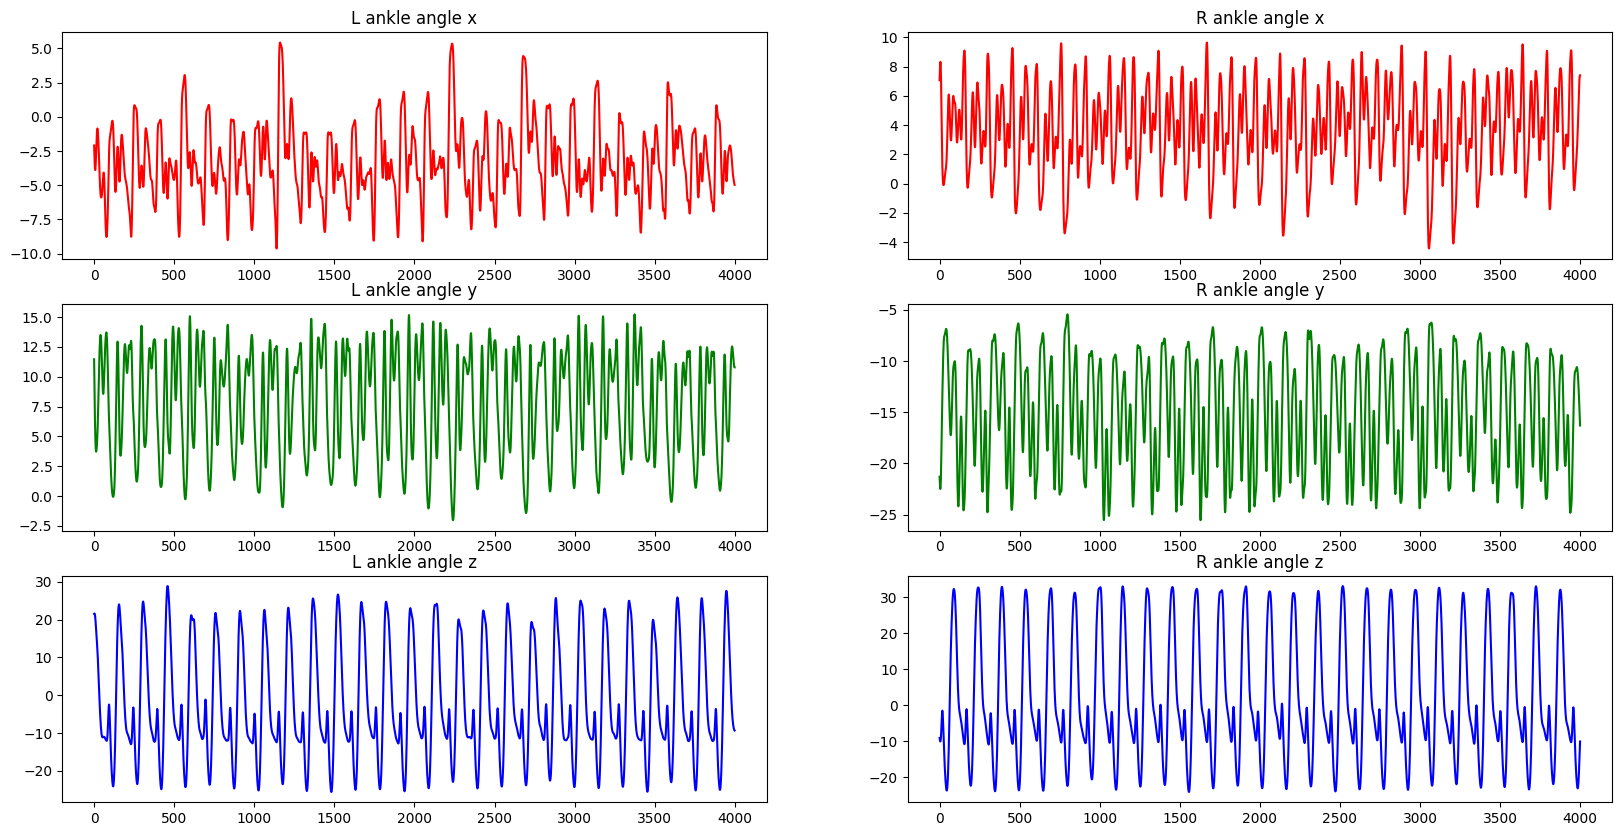

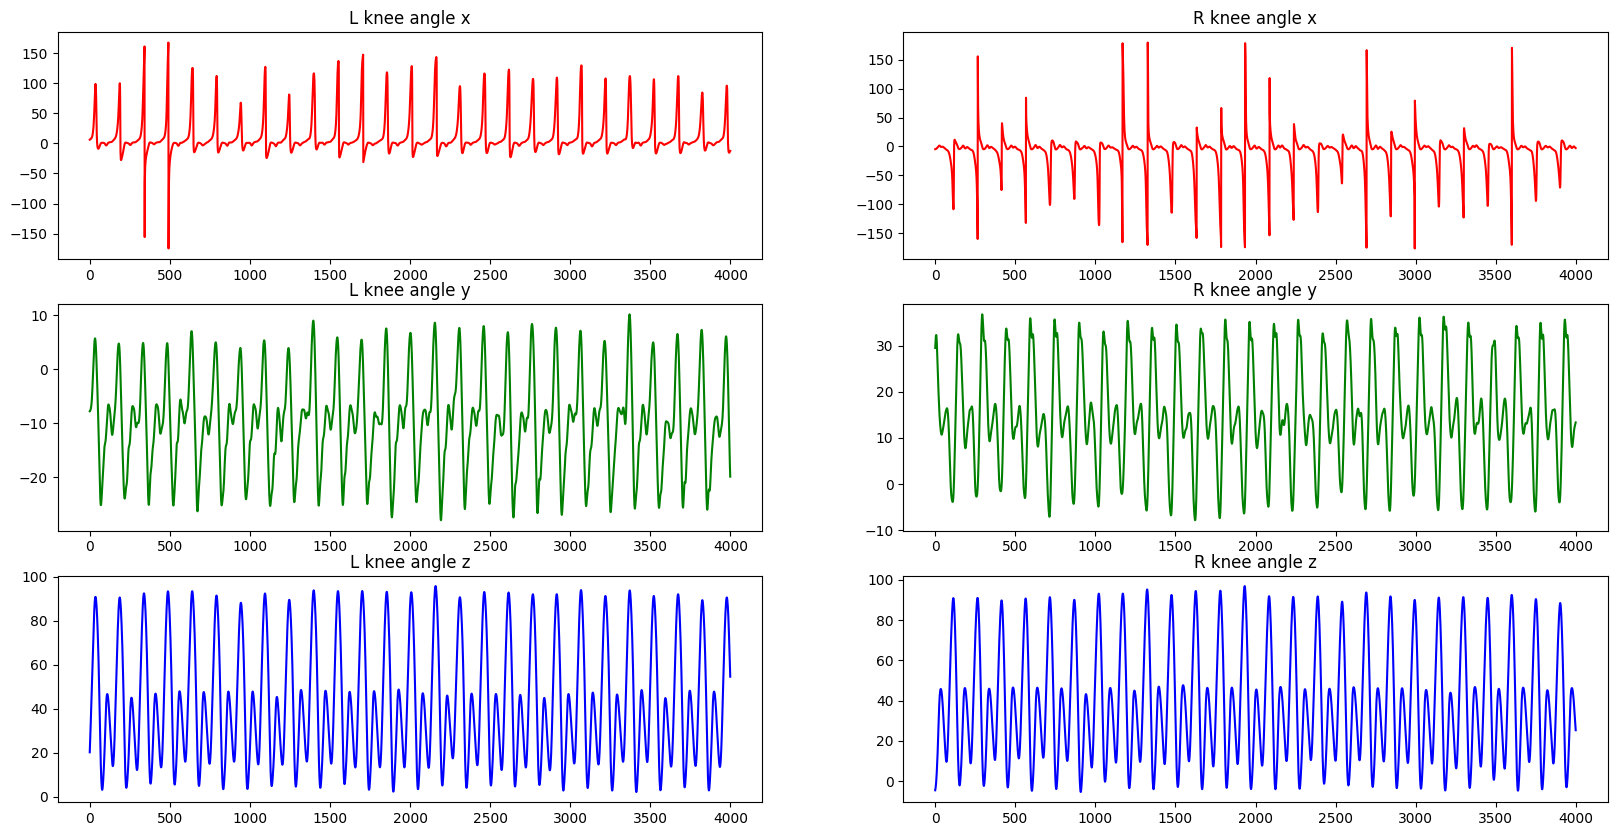

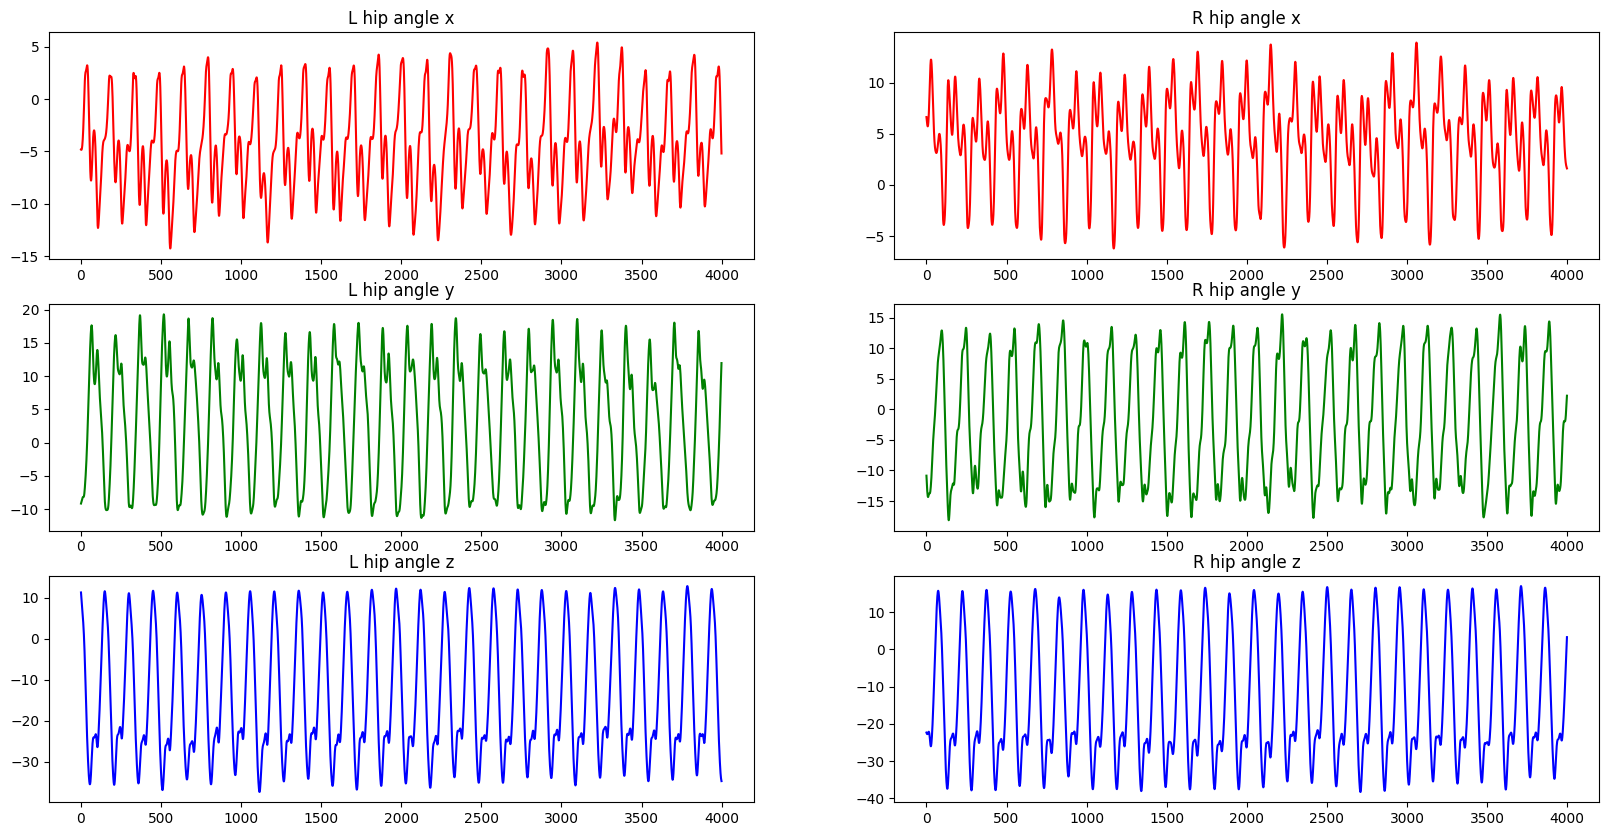

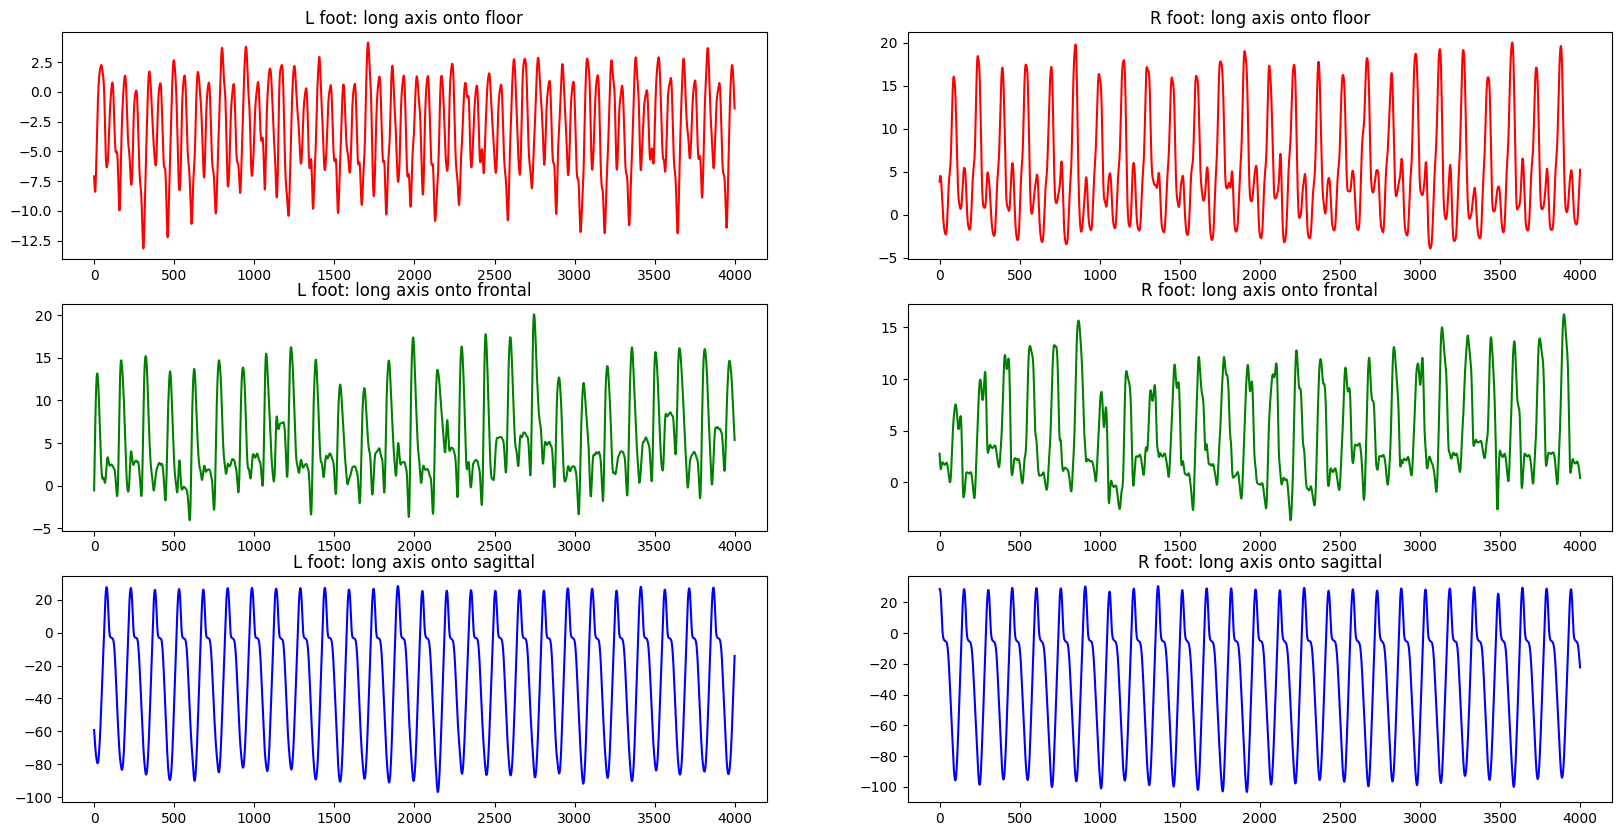

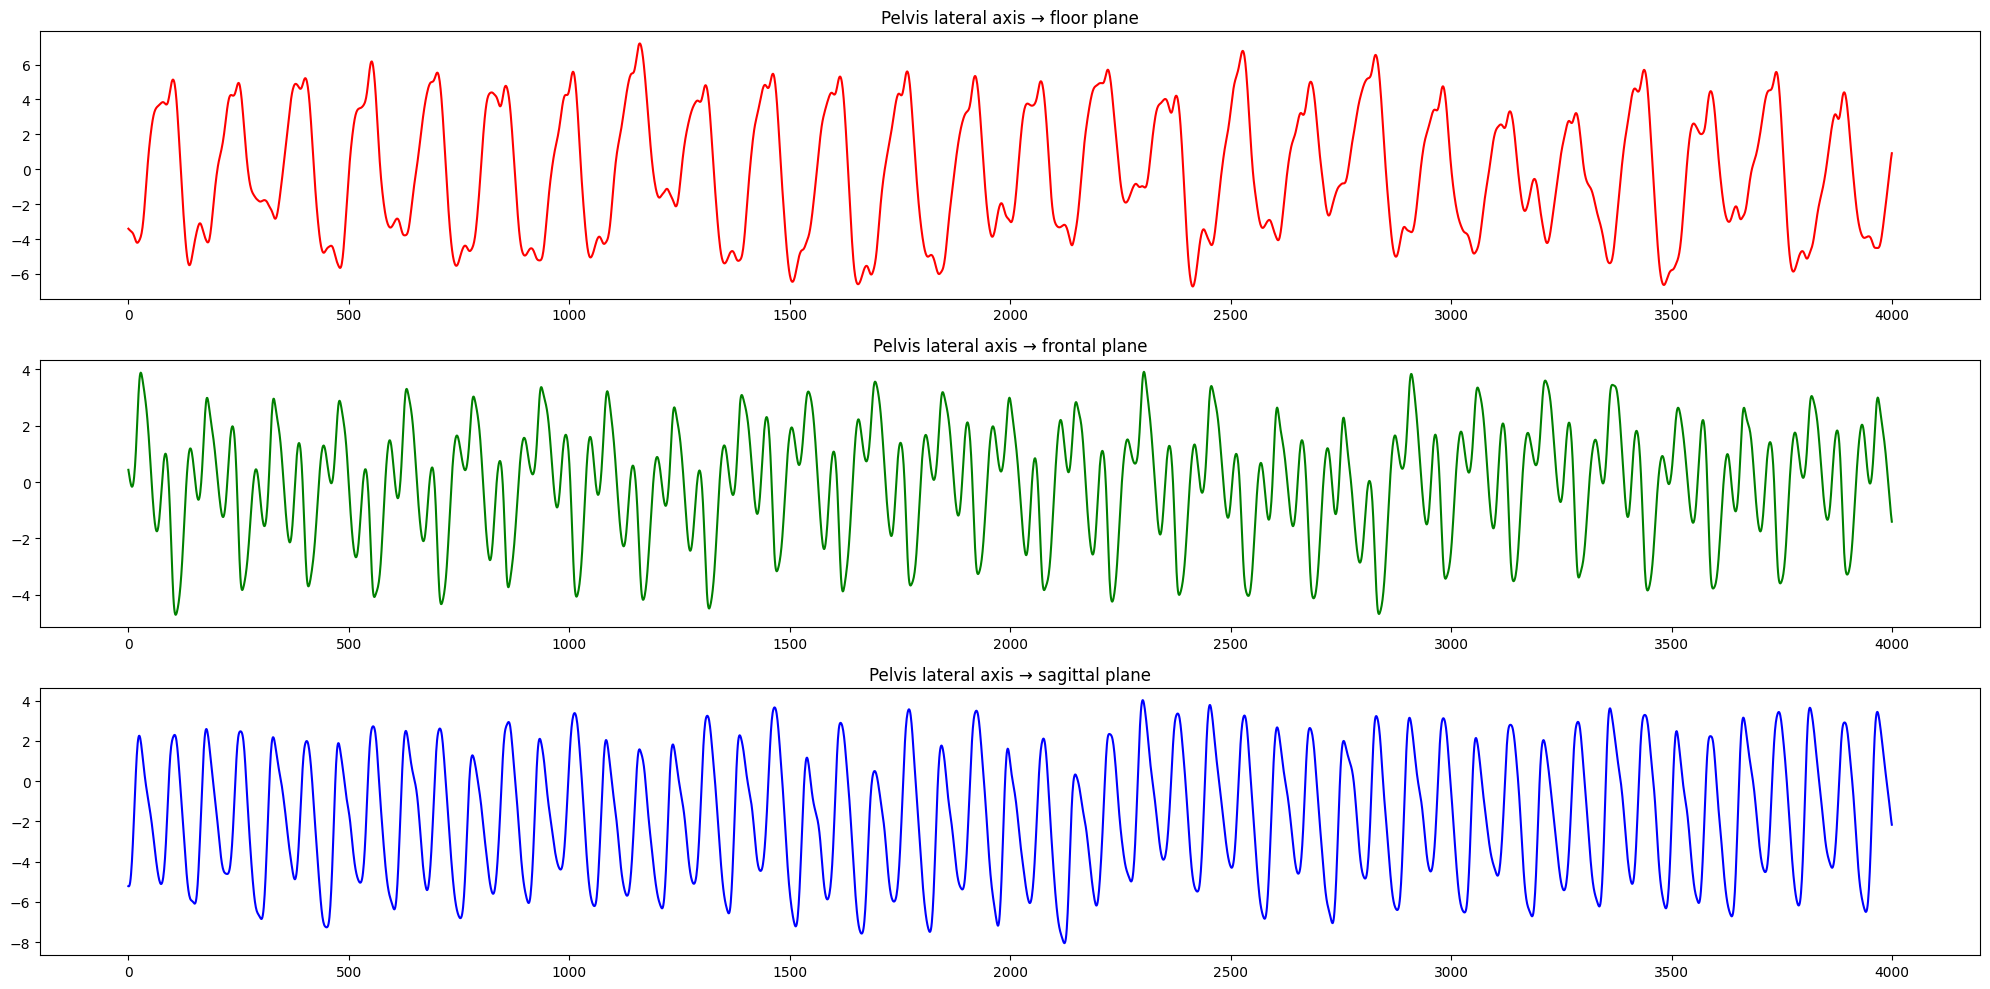

In [44]:

import matplotlib.pyplot as plt


# -------------------------
# LEFT & RIGHT ANKLE ANGLES
# -------------------------
plt.figure(figsize=(20,10))
# Left ankle X, Y, Z
plt.subplot(3, 2, 1)
plt.plot(angles['L_ankle'][:, 0], 'r')
plt.title('L ankle angle x')
plt.subplot(3, 2, 3)
plt.plot(angles['L_ankle'][:, 1], 'g')
plt.title('L ankle angle y')
plt.subplot(3, 2, 5)
plt.plot(angles['L_ankle'][:, 2], 'b')
plt.title('L ankle angle z')
# Right ankle X, Y, Z
plt.subplot(3, 2, 2)
plt.plot(angles['R_ankle'][:, 0], 'r')
plt.title('R ankle angle x')
plt.subplot(3, 2, 4)
plt.plot(angles['R_ankle'][:, 1], 'g')
plt.title('R ankle angle y')
plt.subplot(3, 2, 6)
plt.plot(angles['R_ankle'][:, 2], 'b')
plt.title('R ankle angle z')

# ------------------------
# LEFT & RIGHT KNEE ANGLES
# ------------------------
plt.figure(figsize=(20,10))
# Left knee X, Y, Z
plt.subplot(3, 2, 1)
plt.plot(angles['L_knee'][:, 0], 'r')
plt.title('L knee angle x')
plt.subplot(3, 2, 3)
plt.plot(angles['L_knee'][:, 1], 'g')
plt.title('L knee angle y')
plt.subplot(3, 2, 5)
plt.plot(angles['L_knee'][:, 2], 'b')
plt.title('L knee angle z')
# Right knee X, Y, Z
plt.subplot(3, 2, 2)
plt.plot(angles['R_knee'][:, 0], 'r')
plt.title('R knee angle x')
plt.subplot(3, 2, 4)
plt.plot(angles['R_knee'][:, 1], 'g')
plt.title('R knee angle y')
plt.subplot(3, 2, 6)
plt.plot(angles['R_knee'][:, 2], 'b')
plt.title('R knee angle z')

# -----------------------
# LEFT & RIGHT HIP ANGLES
# -----------------------
plt.figure(figsize=(20,10))
# Left hip X, Y, Z
plt.subplot(3, 2, 1)
plt.plot(angles['L_hip'][:, 0], 'r')
plt.title('L hip angle x')
plt.subplot(3, 2, 3)
plt.plot(angles['L_hip'][:, 1], 'g')
plt.title('L hip angle y')
plt.subplot(3, 2, 5)
plt.plot(angles['L_hip'][:, 2], 'b')
plt.title('L hip angle z')
# Right hip X, Y, Z
plt.subplot(3, 2, 2)
plt.plot(angles['R_hip'][:, 0], 'r')
plt.title('R hip angle x')
plt.subplot(3, 2, 4)
plt.plot(angles['R_hip'][:, 1], 'g')
plt.title('R hip angle y')
plt.subplot(3, 2, 6)
plt.plot(angles['R_hip'][:, 2], 'b')
plt.title('R hip angle z')

# ------------------------
# LEFT & RIGHT FOOT ANGLES
# ------------------------
plt.figure(figsize=(20,10))
# Left foot: long axis onto floor, frontal, sagittal
plt.subplot(3, 2, 1)
plt.plot(angles['L_foot'][:, 0], 'r')
plt.title('L foot: long axis onto floor')
plt.subplot(3, 2, 3)
plt.plot(angles['L_foot'][:, 1], 'g')
plt.title('L foot: long axis onto frontal')
plt.subplot(3, 2, 5)
plt.plot(angles['L_foot'][:, 2], 'b')
plt.title('L foot: long axis onto sagittal')
# Right foot: long axis onto floor, frontal, sagittal
plt.subplot(3, 2, 2)
plt.plot(angles['R_foot'][:, 0], 'r')
plt.title('R foot: long axis onto floor')
plt.subplot(3, 2, 4)
plt.plot(angles['R_foot'][:, 1], 'g')
plt.title('R foot: long axis onto frontal')
plt.subplot(3, 2, 6)
plt.plot(angles['R_foot'][:, 2], 'b')
plt.title('R foot: long axis onto sagittal')

# --------------------------
# PELVIS ANGLES (3 subplots)
# --------------------------
plt.figure(figsize=(20,10))
plt.subplot(3, 1, 1)
plt.plot(angles['pelvis'][:, 0], 'r')
plt.title('Pelvis lateral axis → floor plane')
plt.subplot(3, 1, 2)
plt.plot(angles['pelvis'][:, 1], 'g')
plt.title('Pelvis lateral axis → frontal plane')
plt.subplot(3, 1, 3)
plt.plot(angles['pelvis'][:, 2], 'b')
plt.title('Pelvis lateral axis → sagittal plane')

# Display all figures
plt.tight_layout()
plt.show()

In [62]:
import pandas as pd
ref = pd.read_csv('/mnt/d/code/stridecare/run_data_meta.csv')
ref[ref['filename'] == filepath.split('/')[-1]][['InjDefn', 'InjJoint', 'InjSide']]

,InjDefn,InjJoint,InjSide
400,Training volume/intensity affected,Knee,Bilateral
